# Traffic Sign Recognition Using Deep Learning
One of the applications where deep learning is being used extensively is Autonomous Driving. The autonous driving mechanism needs to detect innumerable objects (pedestrians, other cars, obstacles etc) and make decisions. One of the smaller problems is to detect traffic signs and make decisions accordingly. We are going to solve problems of detecting traffic signs on the road. 

We are going to refer to the following blog[[1]](https://chsasank.github.io/keras-tutorial.html). We are going to use [The German Traffic Sign Recognition Benchmark(GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) dataset. 

The training dataset contains around 39,000 images while test dataset contains around 12,000 images containing 43 different classes. We will be using Convolutional Neural Networks(CNN) to solve this problem using Keras framework and tensorflow as backend.

## Exploring dataset

In [3]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from skimage import color, exposure, transform, io

In [4]:
NUM_CLASSES = 43
IMG_SIZE = 48
TRAINING_PATH = 'data/traffic_sign_dataset/Final_Training/Images/'
TEST_PATH = 'data/traffic_sign_dataset/Final_Test/Images/'
BATCH_SIZE = 32
EPOCHS = 30

In windows, glob might give us mixed separators which will create problem when we extract the class information from image paths, therefore, creating the below functions to fix the image paths.

In [5]:
def correct_all_paths(img_paths):
    new_paths = []
    for path in img_paths:
        path = path.replace('\\', '/')
        new_paths.append(path)
    return new_paths

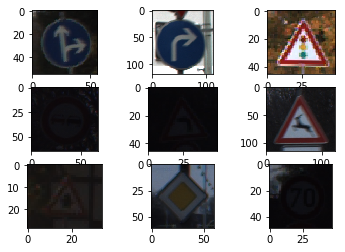

In [27]:
#Look at the first 9 images from the training dataset
img_paths = glob.glob(os.path.join(TRAINING_PATH, '*/*.ppm'))
img_paths = correct_all_paths(img_paths)
np.random.shuffle(img_paths)
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(io.imread(img_paths[i], cmap=plt.get_cmap('gray')))
#Show the plot
plt.show()

## Preprocessing images 

Now, we will use preprocess our images. We need preprocessing for two reasons:
- To normalize intensity across all images i.e if an image is overexposed or underexposed, we will make it well-exposed using [histogram equilization](https://en.wikipedia.org/wiki/Histogram_equalization). As you can see in above pictures, we have many such images.
- To resize all images to same size.

In [6]:
def preprocess_images(img):
    # return image in HSV format
    hsv = color.rgb2hsv(img)
    # return image after histogram equilization
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)
    
    # resizing image to fixed dimension
    min_side = min(img.shape[:-1])
    center =img.shape[0] // 2, img.shape[1] // 2
    img = img[center[0] - min_side // 2: center[0] + min_side // 2,
              center[1] - min_side // 2: center[0] + min_side // 2,
              :]
    img = transform.resize(img,(IMG_SIZE, IMG_SIZE), mode = 'constant')

    return img

We will now preprocess images using preprocess_image function created above and store them in numpy array
and convert target images to one-hot encoding for Keras usage.

In [29]:
def get_class(img_path):
    return int(img_path.split('/')[-2])

In [14]:
images = []
labels = []
for img_path in img_paths:
    img = preprocess_images(io.imread(img_path))
    label = get_class(img_path)
    images.append(img)
    labels.append(label)
X = np.array(images, dtype = 'float32')
Y = np.eye(NUM_CLASSES, dtype = 'uint8')[labels]

Below are the images after preprocessing step

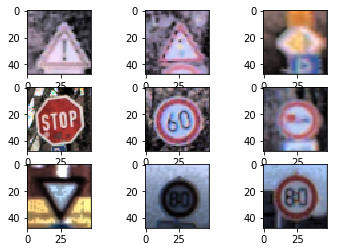

In [30]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i], cmap=plt.get_cmap('gray'))
#Show the plot
plt.show()

## Building Convolutional Neural Network Model
We will now build our sequential CNN model with following specifications:
- 6 convolutional layer followed by one hidden layer and one output layer(fully
    connected or dense layer). 
- Dropout layers for regularization to avoid overfitting
- Relu activation function for all convolutional layers
- Softmax activation function for output layer as it is a multi-class classification problem
- Flatten layer for reshaping the output of the convolutional layer

In [7]:
from keras.models import Sequential
from keras.layers.core import Dropout, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD

Using TensorFlow backend.


In [8]:
def build_cnn_model():
    model = Sequential() 
    model.add(Conv2D(32, (3, 3), padding ='same', input_shape = (IMG_SIZE, IMG_SIZE, 3), activation = 'relu'))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding ='same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding ='same', activation = 'relu'))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = 'softmax'))
    return model

Lets us now compile our model using loss function as categorical_crossentropy

In [39]:
model = build_cnn_model()
lr = 0.01
sgd = SGD(lr = lr, decay = 1e-6, momentum = 0.9, nesterov = True) 
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

We will be using callback feature of keras which are a set of functions like 'LearningRateScheduler', 'ModelCheckpoint' and 'EarlyStopping'.
- Learning rate scheduler will decay learning rate. Slowing learning rate over epochs might help learn model better.
- Model checkpoint will save the model with the best validation accuracy as we progress. This will help in case when our model    starts overfitting. 
- Early Stopping will stop the training if the accuracy gain between 'patience' epochs is not more than a specified value.

In [40]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
def learning_rate_scheduler(epoch):
    return lr * (0.1 ** int(epoch / 10))

## Training the built model
Training the model might take long time using CPU. Because of the parallel nature of the neural networks, they work extremely well with GPUs(NVIDIA GPUs with CUDA).
I used NVIDIA Tesla K80 which significantly decreased the training time by many folds.

In [41]:
import h5py as h5py

In [42]:
model_history = model.fit(X, Y,
                          batch_size = BATCH_SIZE,
                          epochs = EPOCHS,
                          validation_split = 0.2,
                          verbose = 1, 
                          callbacks = [LearningRateScheduler(learning_rate_scheduler),
                                      ModelCheckpoint('model.h5', save_best_only=True),
                                      EarlyStopping(monitor='val_acc', min_delta=0.00001, patience=5, \
                                                     verbose=1, mode='auto')])

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
31367/31367 [==============================] - 28s 908us/step - loss: 1.5244 - acc: 0.5720 - val_loss: 0.2038 - val_acc: 0.9385
Epoch 2/30
31367/31367 [==============================] - 28s 902us/step - loss: 0.2397 - acc: 0.9262 - val_loss: 0.0768 - val_acc: 0.9754
Epoch 3/30
31367/31367 [==============================] - 28s 906us/step - loss: 0.1442 - acc: 0.9557 - val_loss: 0.0636 - val_acc: 0.9818
Epoch 4/30
31367/31367 [==============================] - 28s 896us/step - loss: 0.0979 - acc: 0.9693 - val_loss: 0.0531 - val_acc: 0.9839
Epoch 5/30
31367/31367 [==============================] - 28s 895us/step - loss: 0.0795 - acc: 0.9752 - val_loss: 0.0448 - val_acc: 0.9870
Epoch 6/30
31367/31367 [==============================] - 28s 895us/step - loss: 0.0684 - acc: 0.9789 - val_loss: 0.0292 - val_acc: 0.9907
Epoch 7/30
31367/31367 [==============================] - 28s 892us/step - loss: 0.0559 - acc: 0.9826 - val_loss: 0.0

## Plotting Accuracy and Loss Curves

Summarize history for Accuracy

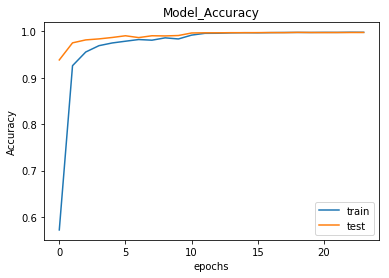

In [43]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model_Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

Summarize history for Loss

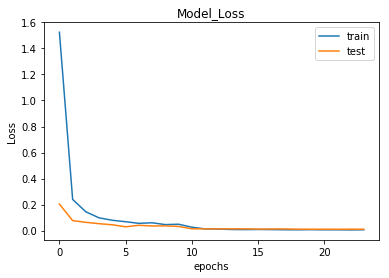

In [44]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model_Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

## Evaluating the trained model

In [45]:
import pandas as pd
test_data = pd.read_csv('data/traffic_sign_dataset/GT-final_test.csv', sep =';' )

# Loading test data
X_test = []
y_test = []
for file_name, class_id in zip(list(test_data['Filename']), list(test_data['ClassId'])):
    img_path = os.path.join('data/traffic_sign_dataset/Final_Test/Images', file_name)
    X_test.append(preprocess_images(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

# predict and evaluate
y_predict = model.predict_classes(X_test)
accuracy = np.sum(y_predict == y_test) / np.size(y_predict)
print("Test accuracy = {}".format(accuracy))

Test accuracy = 0.9730007917656374


## Improving Accuracy using Data Augmentation

This test accuracy is good but we can still improve it using data augmentation. Data augmentation increases the size of training dataset by augmenting images using rotation, shearing, flipping, etc effects.

In [46]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size =0.2, random_state = 42)

datagen = ImageDataGenerator(featurewise_center = False,
                            featurewise_std_normalization = False,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range =0.2,
                            shear_range = 0.1,
                            rotation_range = 10)
datagen.fit(X_train)

In [9]:
# Reinstialize models 
model = build_cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [48]:
model_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size= BATCH_SIZE),
                            steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                            epochs= EPOCHS,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(learning_rate_scheduler),
                                       ModelCheckpoint('model_aug.h5',save_best_only=True),
                                       EarlyStopping(monitor='val_acc', min_delta=0.00001, patience=5, \
                                                     verbose=1, mode='auto')])

Epoch 1/30
981/980 [==============================] - 29s 29ms/step - loss: 2.5942 - acc: 0.2626 - val_loss: 1.0110 - val_acc: 0.6634
Epoch 2/30
981/980 [==============================] - 29s 29ms/step - loss: 0.9451 - acc: 0.6969 - val_loss: 0.1917 - val_acc: 0.9375
Epoch 3/30
981/980 [==============================] - 29s 29ms/step - loss: 0.4393 - acc: 0.8613 - val_loss: 0.0966 - val_acc: 0.9671
Epoch 4/30
981/980 [==============================] - 29s 29ms/step - loss: 0.2914 - acc: 0.9094 - val_loss: 0.0636 - val_acc: 0.9813
Epoch 5/30
981/980 [==============================] - 29s 29ms/step - loss: 0.2242 - acc: 0.9301 - val_loss: 0.0413 - val_acc: 0.9874
Epoch 6/30
981/980 [==============================] - 29s 29ms/step - loss: 0.1878 - acc: 0.9433 - val_loss: 0.0391 - val_acc: 0.9907
Epoch 7/30
981/980 [==============================] - 29s 29ms/step - loss: 0.1610 - acc: 0.9511 - val_loss: 0.0268 - val_acc: 0.9913
Epoch 8/30
981/980 [==============================] - 29s 29ms

Summarize history for Accuracy

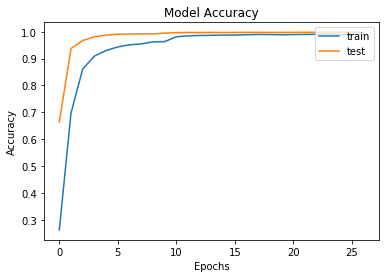

In [49]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

summarize history for loss

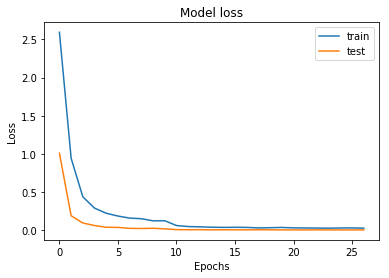

In [50]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [51]:
# predict again and re-evaluate
y_predict = model.predict_classes(X_test)
accuracy = np.sum(y_predict == y_test) / np.size(y_predict)
print("Test accuracy = {}".format(accuracy))

Test accuracy = 0.9844813935075217


## Conclusion

We created a Convolutional Neural Network (CNN) model to classify traffic sign images. We started with exploring our dataset of German traffic signs. Then we performed pre-processing of images (Histogram equalization and rescaling to same size) to make them suitable for CNN. We built a simple CNN model using Keras with 6 convolutional layer followed by one hidden layer, one output layer(fully connected or dense layer). We used dropout layers to avoid overfitting. After that we trained our model with our training dataset. The evaluation of model resulted in 97.3% accuracy. We used data augmentation techniques to further improve accuracy to 98.4%. The human accuracy for this dataset is 98.84%. Pretty Close! 

## References 

1. [Keras Tutorial: Traffic Sign Recognition](https://chsasank.github.io/keras-tutorial.html)
2. [Man vs. Computer:
Benchmarking Machine Learning Algorithms for Traffic Sign Recognition](http://image.diku.dk/igel/paper/MvCBMLAfTSR.pdf)